In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from bnb.problem import OptimizationProblem
from matplotlib import pyplot as plt
import matplotlib
from scipy.optimize import minimize
import pandas as pd
from bnb.fml_solver import FMLSolver
import warnings
import time
from bnb.gradient_descent import GradientDescent
import seaborn as sns

from autograd.scipy.special import logsumexp
from autograd import jacobian
import autograd.numpy as anp

sns.set()
matplotlib.rcParams.update({'font.size': 11, 'font.family': 'serif'})

In [3]:
n = 2
n_choices = int(1e6)
runs = 750
m = 2

In [4]:
class DataSimulator(OptimizationProblem):
    
    def revenue_true(self, p):
        return np.sum([
            segment.w * np.sum(p * segment.purchase_probabilities(p))
            for segment in self.segments
        ])
    
    def simulate_choices(self, n_observations, seed=None):
        
        np.random.seed(seed)
        
        observed_prices = np.random.uniform(self.p_lb, self.p_ub, size=(n_observations, self.n))
        
        purchase_probabilities = np.asarray([
            np.sum([segment.w * segment.purchase_probabilities(price) for segment in self.segments], axis=0)
            for price in observed_prices
        ])
            
        assert purchase_probabilities.shape == (n_observations, self.n)
        
        # 0 is first product, n is no purchase
        observed_choices = np.sum(
            np.cumsum(purchase_probabilities, axis=1) < np.random.uniform(size=(n_observations, 1)),
            axis=1
        )
        
        return observed_prices, observed_choices
    
    
def logit_loglikelihood(params, observed_choices, observed_prices):
    
    assert len(params) == 2 * n
    a, b = params[:n], params[n:]
    n_choices = len(observed_choices)
    
    utilities = a - b * observed_prices
    assert utilities.shape == (n_choices, n)
    
    utilities = anp.concatenate((utilities, anp.zeros((n_choices, 1))), axis=1)
    assert utilities.shape == (n_choices, n + 1)
    
    utilities_chosen_products = utilities[anp.arange(n_choices), observed_choices]
    assert utilities_chosen_products.shape == (n_choices, ), utilities_chosen_products.shape

    log_probs = - logsumexp(utilities - anp.expand_dims(utilities_chosen_products, -1), axis=-1)
    assert log_probs.shape == (n_choices, ), log_probs.shape
    
    return - anp.sum(log_probs) / n_choices

In [5]:
from tqdm import tqdm

results = []
for run in tqdm(range(runs)):
    
    t0 = time.time()
    np.random.seed(run)

    a0 = np.random.uniform(-7, 7, size=(m, n))
    b0 = np.random.uniform(0.001, 0.01, size=n)

    w0 = np.asarray([0.5, 0.5])
    
    gd = GradientDescent(a0, b0, w0)
    gd_sol = gd.solve()

    true_demand = DataSimulator(a0, b0, w0)
    solver = FMLSolver(true_demand, objective_lb=gd_sol, epsilon=0.005)
    solver.solve()

    # Simulate data
    observed_prices, observed_choices = true_demand.simulate_choices(n_choices, seed=run)

    # Estimate logit model
    t0 = time.time()
    a_start = np.mean(a0, axis=0)
    b_start = b0
    best_result = None
    any_success = False
    
    for attempt in range(1):
        
        parameter_start = np.hstack((a_start, b_start))

        with warnings.catch_warnings():
            warnings.filterwarnings(action="ignore", category=RuntimeWarning)
            jac = jacobian(logit_loglikelihood)
            min_ll = minimize(
                logit_loglikelihood,
                parameter_start,
                args=(observed_choices, observed_prices),
                jac=jac
            )
            
        any_success = any_success or min_ll.success

        if best_result is None:
            best_result = min_ll

        if min_ll.fun < best_result.fun:
            best_result = min_ll
        
        a_start, b_start = np.random.uniform(0, 8, size=n), np.random.uniform(0.0, 1.0, size=n)
    
    if not any_success:
        raise ValueError("All optimization attempts failed.")
    
    a, b = best_result.x[:n], best_result.x[n:]
    print(f"estimated logit model in {time.time() - t0:.0f} seconds.")

    # Optimize revenue under logit model specification (i.e., FML with one segment)
    opt = OptimizationProblem(np.asarray([a]), b, np.ones(1))
    opt_logit_prices = 1 / b + opt.segments[0].rev_opt
    p = opt_logit_prices
    logit_rev = true_demand.revenue_true(p)
    opt_rev = solver.objective_lb
    
    results.append({
        "opt_rev": opt_rev,
        "logit_rev": logit_rev,
        "logit_par": (a, b),
        "real_par": (a0, b0, w0),
        "run": run
    })
      
    print(f"logit rev {logit_rev}, opt rev {opt_rev}")

  0%|          | 1/750 [00:42<8:48:02, 42.30s/it]

estimated logit model in 10 seconds.
logit rev 204.28897410840446, opt rev 208.8679195304218


  0%|          | 2/750 [01:31<9:13:44, 44.42s/it]

estimated logit model in 17 seconds.
logit rev 385.9062399507851, opt rev 443.8968559011249


  0%|          | 3/750 [02:20<9:28:13, 45.64s/it]

estimated logit model in 16 seconds.
logit rev 69.71448320462645, opt rev 69.88369860379684


  1%|          | 4/750 [03:05<9:25:40, 45.50s/it]

estimated logit model in 12 seconds.
logit rev 98.33516747041625, opt rev 99.23809944581295


  1%|          | 5/750 [03:55<9:41:21, 46.82s/it]

estimated logit model in 12 seconds.
logit rev 613.8292058004131, opt rev 614.3361724362584


  1%|          | 6/750 [04:45<9:54:34, 47.95s/it]

estimated logit model in 17 seconds.
logit rev 507.4563950506034, opt rev 507.4569498203248


  1%|          | 7/750 [05:39<10:13:54, 49.57s/it]

estimated logit model in 18 seconds.
logit rev 1462.9224269441697, opt rev 1462.9973780895743


  1%|          | 8/750 [06:28<10:12:22, 49.52s/it]

estimated logit model in 15 seconds.
logit rev 320.5624833015411, opt rev 320.58091117794334


  1%|          | 9/750 [07:16<10:04:09, 48.92s/it]

estimated logit model in 11 seconds.
logit rev 1929.7968684773102, opt rev 2148.882590073508


  1%|▏         | 10/750 [08:11<10:26:34, 50.80s/it]

estimated logit model in 20 seconds.
logit rev 105.52778917118206, opt rev 106.47256767456716


  1%|▏         | 11/750 [08:58<10:11:16, 49.63s/it]

estimated logit model in 12 seconds.
logit rev 319.87837881692826, opt rev 494.7362248976186


  2%|▏         | 12/750 [09:46<10:05:11, 49.20s/it]

estimated logit model in 14 seconds.
logit rev 136.83914119187287, opt rev 155.81074891887587


  2%|▏         | 13/750 [10:35<10:05:22, 49.28s/it]

estimated logit model in 15 seconds.
logit rev 115.69637209321066, opt rev 115.89430152084236


  2%|▏         | 14/750 [11:22<9:56:21, 48.62s/it] 

estimated logit model in 15 seconds.
logit rev 245.45602335244828, opt rev 459.3812908341138


  2%|▏         | 15/750 [12:06<9:36:20, 47.05s/it]

estimated logit model in 11 seconds.
logit rev 274.7573040528075, opt rev 516.1902113068306


  2%|▏         | 16/750 [12:55<9:41:36, 47.54s/it]

estimated logit model in 16 seconds.
logit rev 37.87832058432673, opt rev 412.2533851790807


  2%|▏         | 17/750 [13:44<9:47:54, 48.12s/it]

estimated logit model in 16 seconds.
logit rev 111.48385357147174, opt rev 114.82560127753452


  2%|▏         | 18/750 [14:38<10:08:04, 49.84s/it]

estimated logit model in 19 seconds.
logit rev 28.70352660136356, opt rev 28.75339787069453


  3%|▎         | 19/750 [15:26<9:59:44, 49.23s/it] 

estimated logit model in 13 seconds.
logit rev 220.47268200012616, opt rev 223.9746924432294


  3%|▎         | 20/750 [16:12<9:49:33, 48.46s/it]

estimated logit model in 15 seconds.
logit rev 339.18085989765723, opt rev 567.0448371661361


  3%|▎         | 21/750 [16:56<9:30:10, 46.93s/it]

estimated logit model in 11 seconds.
logit rev 1321.795078373094, opt rev 1418.3448432873872


  3%|▎         | 22/750 [17:44<9:32:54, 47.22s/it]

estimated logit model in 15 seconds.
logit rev 234.1314312216964, opt rev 289.45650291924983


  3%|▎         | 23/750 [18:32<9:34:58, 47.45s/it]

estimated logit model in 14 seconds.
logit rev 315.7043106563994, opt rev 372.7417055834035


  3%|▎         | 24/750 [19:18<9:29:34, 47.07s/it]

estimated logit model in 12 seconds.
logit rev 51.11965799990562, opt rev 611.6445122685677


  3%|▎         | 25/750 [20:05<9:30:03, 47.18s/it]

estimated logit model in 14 seconds.
logit rev 999.5200183359174, opt rev 999.8549831242552


  3%|▎         | 26/750 [20:52<9:28:53, 47.15s/it]

estimated logit model in 14 seconds.
logit rev 255.38197623348114, opt rev 344.7783887669513


  4%|▎         | 27/750 [21:36<9:17:18, 46.25s/it]

estimated logit model in 12 seconds.
logit rev 431.4321726505239, opt rev 447.5285309962861


  4%|▎         | 28/750 [22:22<9:15:17, 46.15s/it]

estimated logit model in 12 seconds.
logit rev 324.3609710536381, opt rev 324.4551957081027


  4%|▍         | 29/750 [23:10<9:18:51, 46.51s/it]

estimated logit model in 12 seconds.
logit rev 115.55333094333318, opt rev 118.6224996487243


  4%|▍         | 30/750 [23:56<9:19:14, 46.60s/it]

estimated logit model in 11 seconds.
logit rev 16.138695836219057, opt rev 464.7397593163221


  4%|▍         | 31/750 [24:46<9:27:46, 47.38s/it]

estimated logit model in 14 seconds.
logit rev 114.27193656813739, opt rev 114.27682726277118


  4%|▍         | 32/750 [25:34<9:30:47, 47.70s/it]

estimated logit model in 13 seconds.
logit rev 1870.8223915843873, opt rev 1871.4134634284808


  4%|▍         | 33/750 [26:21<9:25:37, 47.33s/it]

estimated logit model in 11 seconds.
logit rev 0.17956987037298086, opt rev 432.44721695245124


  5%|▍         | 34/750 [27:13<9:43:27, 48.89s/it]

estimated logit model in 17 seconds.
logit rev 36.85195080634791, opt rev 37.12851374593662


  5%|▍         | 35/750 [27:57<9:24:47, 47.39s/it]

estimated logit model in 8 seconds.
logit rev 154.1737846008222, opt rev 154.24837081028593


  5%|▍         | 36/750 [28:44<9:21:37, 47.19s/it]

estimated logit model in 11 seconds.
logit rev 19.83565197393391, opt rev 19.838208229626538


  5%|▍         | 37/750 [29:32<9:25:36, 47.60s/it]

estimated logit model in 12 seconds.
logit rev 339.68708516375375, opt rev 347.1056440282568


  5%|▌         | 38/750 [30:22<9:33:21, 48.32s/it]

estimated logit model in 12 seconds.
logit rev 7.084918200147076, opt rev 333.74288021325395


  5%|▌         | 39/750 [31:09<9:25:51, 47.75s/it]

estimated logit model in 10 seconds.
logit rev 15.768914730456741, opt rev 518.517695953967


  5%|▌         | 40/750 [31:57<9:25:52, 47.82s/it]

estimated logit model in 11 seconds.
logit rev 16.84746494907251, opt rev 402.85492040264234


  5%|▌         | 41/750 [32:47<9:34:59, 48.66s/it]

estimated logit model in 16 seconds.
logit rev 169.70882054269754, opt rev 224.8250508090779


  6%|▌         | 42/750 [33:43<9:58:01, 50.68s/it]

estimated logit model in 20 seconds.
logit rev 286.33510497308487, opt rev 307.30269007355


  6%|▌         | 43/750 [34:29<9:40:27, 49.26s/it]

estimated logit model in 11 seconds.
logit rev 598.293890455248, opt rev 1181.701324770296


  6%|▌         | 44/750 [35:12<9:17:22, 47.37s/it]

estimated logit model in 9 seconds.
logit rev 44.89807425190196, opt rev 45.35267528113058


  6%|▌         | 45/750 [36:03<9:31:01, 48.60s/it]

estimated logit model in 15 seconds.
logit rev 518.9586323312361, opt rev 519.0324465203253


  6%|▌         | 46/750 [36:56<9:46:59, 50.03s/it]

estimated logit model in 16 seconds.
logit rev 6.33956665492815, opt rev 437.34818160781026


  6%|▋         | 47/750 [37:43<9:34:54, 49.07s/it]

estimated logit model in 11 seconds.
logit rev 221.94803545643293, opt rev 380.21284553058035


  6%|▋         | 48/750 [38:38<9:54:23, 50.80s/it]

estimated logit model in 11 seconds.
logit rev 6.077509885059187, opt rev 370.7829147191041


  7%|▋         | 49/750 [39:32<10:03:49, 51.68s/it]

estimated logit model in 18 seconds.
logit rev 15.639149616732174, opt rev 421.22950854416945


  7%|▋         | 50/750 [40:20<9:52:06, 50.75s/it] 

estimated logit model in 12 seconds.
logit rev 240.307586960202, opt rev 305.2293652178908


  7%|▋         | 51/750 [41:13<9:57:36, 51.30s/it]

estimated logit model in 18 seconds.
logit rev 35.09351742472147, opt rev 35.1706864261661


  7%|▋         | 52/750 [42:04<9:55:15, 51.17s/it]

estimated logit model in 14 seconds.
logit rev 190.09467137742305, opt rev 229.01964648160518


  7%|▋         | 53/750 [43:01<10:14:29, 52.90s/it]

estimated logit model in 18 seconds.
logit rev 146.85993711048573, opt rev 747.4520244529647


  7%|▋         | 54/750 [43:51<10:04:25, 52.11s/it]

estimated logit model in 14 seconds.
logit rev 198.21727149331392, opt rev 230.72672100135327


  7%|▋         | 55/750 [44:47<10:18:38, 53.41s/it]

estimated logit model in 19 seconds.
logit rev 69.01072814537633, opt rev 69.73465714761682


  7%|▋         | 56/750 [45:40<10:14:32, 53.13s/it]

estimated logit model in 15 seconds.
logit rev 0.4511687454593403, opt rev 604.7621168957536


  8%|▊         | 57/750 [46:33<10:12:09, 53.00s/it]

estimated logit model in 16 seconds.
logit rev 537.1883559905498, opt rev 553.0105049309243


  8%|▊         | 58/750 [47:16<9:38:09, 50.13s/it] 

estimated logit model in 12 seconds.
logit rev 10.414314385159193, opt rev 10.485267633073112


  8%|▊         | 59/750 [48:04<9:28:29, 49.36s/it]

estimated logit model in 17 seconds.
logit rev 45.99190781583002, opt rev 46.64572040161872


  8%|▊         | 60/750 [48:43<8:54:14, 46.46s/it]

estimated logit model in 8 seconds.
logit rev 535.5488704396407, opt rev 535.5801613175


  8%|▊         | 61/750 [49:29<8:50:45, 46.22s/it]

estimated logit model in 15 seconds.
logit rev 121.7411855034952, opt rev 129.1982989708386


  8%|▊         | 62/750 [50:15<8:48:56, 46.13s/it]

estimated logit model in 14 seconds.
logit rev 319.5720554661234, opt rev 319.67099270201385


  8%|▊         | 63/750 [50:59<8:41:19, 45.53s/it]

estimated logit model in 13 seconds.
logit rev 62.76964677384762, opt rev 243.8668244483481


  9%|▊         | 64/750 [51:45<8:42:19, 45.68s/it]

estimated logit model in 15 seconds.
logit rev 133.3214760596152, opt rev 135.8966585515343


  9%|▊         | 65/750 [52:30<8:39:15, 45.48s/it]

estimated logit model in 14 seconds.
logit rev 146.30000098410093, opt rev 149.97793123680907


  9%|▉         | 66/750 [53:04<7:58:32, 41.98s/it]

estimated logit model in 4 seconds.
logit rev 4.1081054031290245, opt rev 4.252765180163004


  9%|▉         | 67/750 [53:50<8:11:33, 43.18s/it]

estimated logit model in 15 seconds.
logit rev 186.90369484423957, opt rev 196.67089187889624


  9%|▉         | 68/750 [54:32<8:06:45, 42.82s/it]

estimated logit model in 11 seconds.
logit rev 410.5505068040833, opt rev 778.8144076167403


  9%|▉         | 69/750 [55:14<8:04:35, 42.70s/it]

estimated logit model in 12 seconds.
logit rev 48.758009219098646, opt rev 48.92521066284117


  9%|▉         | 70/750 [55:58<8:07:02, 42.97s/it]

estimated logit model in 13 seconds.
logit rev 711.9523794886186, opt rev 711.9576562256973


  9%|▉         | 71/750 [56:39<8:00:54, 42.50s/it]

estimated logit model in 10 seconds.
logit rev 1248.3462150076598, opt rev 1421.4222642193745


 10%|▉         | 72/750 [57:26<8:13:53, 43.71s/it]

estimated logit model in 15 seconds.
logit rev 29.341233012563528, opt rev 148.40665797540768


 10%|▉         | 73/750 [58:09<8:11:23, 43.55s/it]

estimated logit model in 12 seconds.
logit rev 132.00618197061317, opt rev 148.37312349135314


 10%|▉         | 74/750 [58:53<8:10:57, 43.58s/it]

estimated logit model in 13 seconds.
logit rev 256.00359322978267, opt rev 259.26077824233005


 10%|█         | 75/750 [59:36<8:10:00, 43.56s/it]

estimated logit model in 12 seconds.
logit rev 31.56087136363235, opt rev 589.3376220321152


 10%|█         | 76/750 [1:00:18<8:04:16, 43.11s/it]

estimated logit model in 11 seconds.
logit rev 276.8670948246534, opt rev 330.86130624869566


 10%|█         | 77/750 [1:01:05<8:17:13, 44.33s/it]

estimated logit model in 16 seconds.
logit rev 50.89856308042765, opt rev 141.0547747433251


 10%|█         | 78/750 [1:01:52<8:24:51, 45.08s/it]

estimated logit model in 14 seconds.
logit rev 1409.1746791423534, opt rev 1410.774412981199


 11%|█         | 79/750 [1:02:36<8:21:14, 44.82s/it]

estimated logit model in 13 seconds.
logit rev 346.84161956749597, opt rev 349.97936119540265


 11%|█         | 80/750 [1:03:22<8:23:09, 45.06s/it]

estimated logit model in 15 seconds.
logit rev 51.972317171140446, opt rev 51.97548169998434


 11%|█         | 81/750 [1:04:06<8:18:29, 44.71s/it]

estimated logit model in 13 seconds.
logit rev 187.2976504316572, opt rev 187.31054412370685


 11%|█         | 82/750 [1:04:49<8:12:33, 44.24s/it]

estimated logit model in 12 seconds.
logit rev 579.5210668095453, opt rev 1156.656127831982


 11%|█         | 83/750 [1:05:32<8:08:21, 43.93s/it]

estimated logit model in 12 seconds.
logit rev 164.93900357071945, opt rev 166.58821189274647


 11%|█         | 84/750 [1:06:16<8:05:31, 43.74s/it]

estimated logit model in 12 seconds.
logit rev 395.68568797975786, opt rev 396.57279249523515


 11%|█▏        | 85/750 [1:07:04<8:19:13, 45.04s/it]

estimated logit model in 17 seconds.
logit rev 216.54834784351792, opt rev 217.77705079425553


 11%|█▏        | 86/750 [1:07:46<8:10:21, 44.31s/it]

estimated logit model in 11 seconds.
logit rev 204.47513761053816, opt rev 222.15720563749483


 12%|█▏        | 87/750 [1:08:34<8:21:31, 45.39s/it]

estimated logit model in 17 seconds.
logit rev 89.79110709596401, opt rev 138.37306405302388


 12%|█▏        | 88/750 [1:09:17<8:13:37, 44.74s/it]

estimated logit model in 12 seconds.
logit rev 666.5878683643165, opt rev 890.0131798592193


 12%|█▏        | 89/750 [1:09:58<7:59:29, 43.52s/it]

estimated logit model in 9 seconds.
logit rev 147.5808893438682, opt rev 294.27945309089625


 12%|█▏        | 90/750 [1:10:40<7:54:40, 43.15s/it]

estimated logit model in 12 seconds.
logit rev 27.730762641756954, opt rev 28.271618980996212


 12%|█▏        | 91/750 [1:11:23<7:53:42, 43.13s/it]

estimated logit model in 12 seconds.
logit rev 654.0209819020905, opt rev 820.7603619697106


 12%|█▏        | 92/750 [1:11:58<7:23:48, 40.47s/it]

estimated logit model in 4 seconds.
logit rev 3.170852257219415, opt rev 5.508716040908217


 12%|█▏        | 93/750 [1:12:42<7:35:43, 41.62s/it]

estimated logit model in 13 seconds.
logit rev 841.1624944895968, opt rev 1620.5405662548876


 13%|█▎        | 94/750 [1:13:23<7:32:30, 41.39s/it]

estimated logit model in 10 seconds.
logit rev 349.2843176718648, opt rev 368.34232274533605


 13%|█▎        | 95/750 [1:14:05<7:33:32, 41.55s/it]

estimated logit model in 11 seconds.
logit rev 307.1168010423112, opt rev 307.149095965283


 13%|█▎        | 96/750 [1:14:48<7:37:09, 41.94s/it]

estimated logit model in 12 seconds.
logit rev 195.03752973997905, opt rev 279.9193967160408


 13%|█▎        | 97/750 [1:15:32<7:44:27, 42.68s/it]

estimated logit model in 13 seconds.
logit rev 1669.8354785912984, opt rev 1674.4108834575509


 13%|█▎        | 98/750 [1:16:15<7:44:54, 42.78s/it]

estimated logit model in 12 seconds.
logit rev 308.85152377372077, opt rev 563.6464915109119


 13%|█▎        | 99/750 [1:16:56<7:38:23, 42.25s/it]

estimated logit model in 10 seconds.
logit rev 609.636799499866, opt rev 703.5251956703285


 13%|█▎        | 100/750 [1:17:41<7:45:27, 42.96s/it]

estimated logit model in 13 seconds.
logit rev 221.19479085007205, opt rev 221.97386070046093


 13%|█▎        | 101/750 [1:18:24<7:44:52, 42.98s/it]

estimated logit model in 12 seconds.
logit rev 274.5147548194327, opt rev 878.6723300714098


 14%|█▎        | 102/750 [1:19:09<7:51:39, 43.67s/it]

estimated logit model in 14 seconds.
logit rev 44.234290685997074, opt rev 44.61862607941008


 14%|█▎        | 103/750 [1:19:52<7:47:16, 43.33s/it]

estimated logit model in 11 seconds.
logit rev 194.51531730634326, opt rev 195.44489546940878


 14%|█▍        | 104/750 [1:20:35<7:48:20, 43.50s/it]

estimated logit model in 13 seconds.
logit rev 54.52584166834527, opt rev 265.33208378909495


 14%|█▍        | 105/750 [1:21:23<8:00:39, 44.71s/it]

estimated logit model in 17 seconds.
logit rev 150.69812182580955, opt rev 453.2936073231566


 14%|█▍        | 106/750 [1:22:08<8:01:27, 44.86s/it]

estimated logit model in 14 seconds.
logit rev 29.766634070837306, opt rev 264.3754967292848


 14%|█▍        | 107/750 [1:22:52<7:58:47, 44.68s/it]

estimated logit model in 13 seconds.
logit rev 271.5490945825662, opt rev 278.20110697096794


 14%|█▍        | 108/750 [1:23:37<7:56:25, 44.53s/it]

estimated logit model in 13 seconds.
logit rev 288.31283554236774, opt rev 468.9480704351406


 15%|█▍        | 109/750 [1:24:18<7:45:20, 43.56s/it]

estimated logit model in 11 seconds.
logit rev 43.133399262482705, opt rev 43.26628367494592


 15%|█▍        | 110/750 [1:25:02<7:44:43, 43.57s/it]

estimated logit model in 12 seconds.
logit rev 142.68128474194714, opt rev 142.96686650388506


 15%|█▍        | 111/750 [1:25:46<7:47:52, 43.93s/it]

estimated logit model in 14 seconds.
logit rev 134.32660125081102, opt rev 134.34709407131038


 15%|█▍        | 112/750 [1:26:28<7:40:27, 43.30s/it]

estimated logit model in 11 seconds.
logit rev 296.070082092902, opt rev 543.1499190943283


 15%|█▌        | 113/750 [1:27:11<7:37:16, 43.07s/it]

estimated logit model in 11 seconds.
logit rev 9.436765673582974, opt rev 303.90162815323106


 15%|█▌        | 114/750 [1:27:57<7:47:13, 44.08s/it]

estimated logit model in 15 seconds.
logit rev 1433.349470139819, opt rev 1433.3528708585618


 15%|█▌        | 115/750 [1:28:40<7:42:53, 43.74s/it]

estimated logit model in 12 seconds.
logit rev 5.7632449363049805, opt rev 591.0199367418005


 15%|█▌        | 116/750 [1:29:25<7:45:11, 44.02s/it]

estimated logit model in 14 seconds.
logit rev 365.26949598850956, opt rev 365.6699474140299


 16%|█▌        | 117/750 [1:30:15<8:04:24, 45.92s/it]

estimated logit model in 20 seconds.
logit rev 40.48500908729148, opt rev 1812.4006244136572


 16%|█▌        | 118/750 [1:30:59<7:56:31, 45.24s/it]

estimated logit model in 13 seconds.
logit rev 32.29093489827836, opt rev 201.66753905094603


 16%|█▌        | 119/750 [1:31:41<7:45:37, 44.28s/it]

estimated logit model in 11 seconds.
logit rev 0.15989958567715665, opt rev 468.1010177627036


 16%|█▌        | 120/750 [1:32:22<7:36:06, 43.44s/it]

estimated logit model in 10 seconds.
logit rev 609.0956461438053, opt rev 848.7818218040275


 16%|█▌        | 121/750 [1:33:03<7:26:03, 42.55s/it]

estimated logit model in 9 seconds.
logit rev 207.69017431905257, opt rev 207.69527802840696


 16%|█▋        | 122/750 [1:33:36<6:57:14, 39.86s/it]

estimated logit model in 3 seconds.
logit rev 1.5175880322643627, opt rev 1.5830066090609092


 16%|█▋        | 123/750 [1:34:20<7:09:01, 41.06s/it]

estimated logit model in 13 seconds.
logit rev 119.78541985475378, opt rev 121.23179171041093


 17%|█▋        | 124/750 [1:35:03<7:13:59, 41.60s/it]

estimated logit model in 12 seconds.
logit rev 116.86677146044039, opt rev 143.61497310088774


 17%|█▋        | 125/750 [1:35:46<7:16:59, 41.95s/it]

estimated logit model in 12 seconds.
logit rev 289.6646058119428, opt rev 335.4600404346665


 17%|█▋        | 126/750 [1:36:32<7:29:32, 43.23s/it]

estimated logit model in 15 seconds.
logit rev 268.65908544690035, opt rev 268.70075308268633


 17%|█▋        | 127/750 [1:37:05<6:56:34, 40.12s/it]

estimated logit model in 3 seconds.
logit rev 0.5828321276557125, opt rev 0.5832708402299289


 17%|█▋        | 128/750 [1:37:50<7:11:27, 41.62s/it]

estimated logit model in 14 seconds.
logit rev 311.7255639075299, opt rev 616.3159030316981


 17%|█▋        | 129/750 [1:38:37<7:28:00, 43.29s/it]

estimated logit model in 16 seconds.
logit rev 25.925740217884712, opt rev 480.2967675576199


 17%|█▋        | 130/750 [1:39:24<7:36:55, 44.22s/it]

estimated logit model in 16 seconds.
logit rev 67.9176085276637, opt rev 67.94148816897153


 17%|█▋        | 131/750 [1:40:11<7:47:46, 45.34s/it]

estimated logit model in 18 seconds.
logit rev 46.03232445366187, opt rev 46.29902544675587


 18%|█▊        | 132/750 [1:40:57<7:46:21, 45.28s/it]

estimated logit model in 14 seconds.
logit rev 951.1966272920889, opt rev 978.0602854809533


 18%|█▊        | 133/750 [1:41:39<7:35:48, 44.32s/it]

estimated logit model in 11 seconds.
logit rev 369.6639800695661, opt rev 371.4523778526488


 18%|█▊        | 134/750 [1:42:21<7:27:55, 43.63s/it]

estimated logit model in 12 seconds.
logit rev 11.158344358362088, opt rev 11.22881722804


 18%|█▊        | 135/750 [1:43:02<7:18:27, 42.78s/it]

estimated logit model in 10 seconds.
logit rev 17.317766265192656, opt rev 357.2801880150213


 18%|█▊        | 136/750 [1:43:46<7:22:11, 43.21s/it]

estimated logit model in 13 seconds.
logit rev 66.32412613115847, opt rev 688.6468467133673


 18%|█▊        | 137/750 [1:44:19<6:50:49, 40.21s/it]

estimated logit model in 3 seconds.
logit rev 2.129820898336274, opt rev 2.137723224762813


 18%|█▊        | 138/750 [1:45:02<6:58:17, 41.01s/it]

estimated logit model in 11 seconds.
logit rev 459.4207806653772, opt rev 497.52986880950556


 19%|█▊        | 139/750 [1:45:48<7:12:23, 42.46s/it]

estimated logit model in 13 seconds.
logit rev 1362.0060917805552, opt rev 1372.0350560691202


 19%|█▊        | 140/750 [1:46:31<7:15:29, 42.84s/it]

estimated logit model in 12 seconds.
logit rev 1090.5471637243913, opt rev 1111.5526299258677


 19%|█▉        | 141/750 [1:47:18<7:25:28, 43.89s/it]

estimated logit model in 16 seconds.
logit rev 624.1961331841144, opt rev 913.0384571383377


 19%|█▉        | 142/750 [1:48:02<7:24:31, 43.87s/it]

estimated logit model in 13 seconds.
logit rev 94.46759648948186, opt rev 266.98006206333474


 19%|█▉        | 143/750 [1:48:43<7:17:39, 43.26s/it]

estimated logit model in 11 seconds.
logit rev 91.86075789621688, opt rev 1238.737263197402


 19%|█▉        | 144/750 [1:49:26<7:15:39, 43.13s/it]

estimated logit model in 12 seconds.
logit rev 152.75326332339577, opt rev 157.76750106258027


 19%|█▉        | 145/750 [1:50:11<7:19:11, 43.56s/it]

estimated logit model in 14 seconds.
logit rev 7.285465997880129, opt rev 309.18769487337596


 19%|█▉        | 146/750 [1:50:53<7:13:02, 43.02s/it]

estimated logit model in 11 seconds.
logit rev 29.211816972629702, opt rev 29.21907021116961


 20%|█▉        | 147/750 [1:51:38<7:18:52, 43.67s/it]

estimated logit model in 14 seconds.
logit rev 64.32355830935313, opt rev 64.78341394421014


 20%|█▉        | 148/750 [1:52:21<7:17:06, 43.57s/it]

estimated logit model in 12 seconds.
logit rev 120.69540898863106, opt rev 120.70709855204203


 20%|█▉        | 149/750 [1:53:10<7:32:12, 45.14s/it]

estimated logit model in 18 seconds.
logit rev 47.7162836310946, opt rev 47.859077699337966


 20%|██        | 150/750 [1:53:50<7:17:40, 43.77s/it]

estimated logit model in 10 seconds.
logit rev 427.3281301735945, opt rev 429.73014690112655


 20%|██        | 151/750 [1:54:34<7:14:57, 43.57s/it]

estimated logit model in 12 seconds.
logit rev 467.80591683774685, opt rev 471.7304559380716


 20%|██        | 152/750 [1:55:15<7:08:31, 43.00s/it]

estimated logit model in 11 seconds.
logit rev 18.87912466416261, opt rev 314.89972437274133


 20%|██        | 153/750 [1:56:01<7:15:14, 43.74s/it]

estimated logit model in 14 seconds.
logit rev 322.73213704353157, opt rev 506.0755990982916


 21%|██        | 154/750 [1:56:47<7:20:54, 44.39s/it]

estimated logit model in 15 seconds.
logit rev 46.25104647107591, opt rev 46.8291957045427


 21%|██        | 155/750 [1:57:28<7:12:20, 43.60s/it]

estimated logit model in 11 seconds.
logit rev 258.69732921037905, opt rev 269.07654512331897


 21%|██        | 156/750 [1:58:11<7:10:13, 43.46s/it]

estimated logit model in 12 seconds.
logit rev 700.2744928332617, opt rev 734.935709185919


 21%|██        | 157/750 [1:59:00<7:26:03, 45.13s/it]

estimated logit model in 18 seconds.
logit rev 32.75210180932295, opt rev 32.89370688621869


 21%|██        | 158/750 [1:59:44<7:21:17, 44.73s/it]

estimated logit model in 13 seconds.
logit rev 134.240066254827, opt rev 159.63879532064172


 21%|██        | 159/750 [2:00:28<7:18:10, 44.48s/it]

estimated logit model in 13 seconds.
logit rev 51.17005652839476, opt rev 51.93316893836947


 21%|██▏       | 160/750 [2:01:12<7:15:33, 44.29s/it]

estimated logit model in 13 seconds.
logit rev 134.6293773044172, opt rev 330.52015524331927


 21%|██▏       | 161/750 [2:01:57<7:18:07, 44.63s/it]

estimated logit model in 14 seconds.
logit rev 93.76688667480182, opt rev 222.1742894122114


 22%|██▏       | 162/750 [2:02:48<7:33:26, 46.27s/it]

estimated logit model in 19 seconds.
logit rev 15.309357164477854, opt rev 630.0539919254016


 22%|██▏       | 163/750 [2:03:29<7:18:20, 44.81s/it]

estimated logit model in 10 seconds.
logit rev 137.3291551068819, opt rev 296.0890311394081


 22%|██▏       | 164/750 [2:04:13<7:16:25, 44.69s/it]

estimated logit model in 13 seconds.
logit rev 129.8149279062349, opt rev 131.426468287322


 22%|██▏       | 165/750 [2:04:57<7:11:54, 44.30s/it]

estimated logit model in 13 seconds.
logit rev 53.67274119820497, opt rev 180.04106697006878


 22%|██▏       | 166/750 [2:05:39<7:04:48, 43.64s/it]

estimated logit model in 10 seconds.
logit rev 361.9374198912617, opt rev 366.4095956621005


 22%|██▏       | 167/750 [2:06:19<6:54:46, 42.69s/it]

estimated logit model in 10 seconds.
logit rev 21.34955263682215, opt rev 330.64867019201347


 22%|██▏       | 168/750 [2:07:05<7:03:03, 43.61s/it]

estimated logit model in 15 seconds.
logit rev 10.17837792463095, opt rev 174.4837139456187


 23%|██▎       | 169/750 [2:07:50<7:06:32, 44.05s/it]

estimated logit model in 14 seconds.
logit rev 54.37346078516046, opt rev 54.6729453807276


 23%|██▎       | 170/750 [2:08:32<7:00:45, 43.53s/it]

estimated logit model in 11 seconds.
logit rev 212.13612323275635, opt rev 302.9365638423766


 23%|██▎       | 171/750 [2:09:22<7:17:20, 45.32s/it]

estimated logit model in 19 seconds.
logit rev 26.8822978039121, opt rev 26.88318872247878


 23%|██▎       | 172/750 [2:10:04<7:07:59, 44.43s/it]

estimated logit model in 11 seconds.
logit rev 1177.376362201598, opt rev 1177.4183001473589


 23%|██▎       | 173/750 [2:10:50<7:10:34, 44.77s/it]

estimated logit model in 15 seconds.
logit rev 66.21082348249278, opt rev 70.23253632465915


 23%|██▎       | 174/750 [2:11:33<7:04:24, 44.21s/it]

estimated logit model in 12 seconds.
logit rev 144.4427303158141, opt rev 145.63172052622772


 23%|██▎       | 175/750 [2:12:23<7:20:28, 45.96s/it]

estimated logit model in 19 seconds.
logit rev 23.445292642665766, opt rev 1029.6568403223275


 23%|██▎       | 176/750 [2:13:09<7:19:07, 45.90s/it]

estimated logit model in 14 seconds.
logit rev 1129.186518844319, opt rev 1139.8031467163282


 24%|██▎       | 177/750 [2:13:53<7:14:31, 45.50s/it]

estimated logit model in 14 seconds.
logit rev 61.41349898659496, opt rev 128.6640374078768


 24%|██▎       | 178/750 [2:14:36<7:07:31, 44.85s/it]

estimated logit model in 12 seconds.
logit rev 138.61129277984162, opt rev 189.29262281134984


 24%|██▍       | 179/750 [2:15:19<6:59:57, 44.13s/it]

estimated logit model in 11 seconds.
logit rev 124.66948346704194, opt rev 132.96424730209097


 24%|██▍       | 180/750 [2:16:01<6:54:02, 43.58s/it]

estimated logit model in 11 seconds.
logit rev 788.8689699879685, opt rev 813.7959347915369


 24%|██▍       | 181/750 [2:16:38<6:34:19, 41.58s/it]

estimated logit model in 6 seconds.
logit rev 98.19592607480827, opt rev 98.1978245727069


 24%|██▍       | 182/750 [2:17:22<6:41:09, 42.38s/it]

estimated logit model in 13 seconds.
logit rev 181.62812560932454, opt rev 181.67780368611307


 24%|██▍       | 183/750 [2:18:05<6:40:54, 42.42s/it]

estimated logit model in 11 seconds.
logit rev 70.90073471486866, opt rev 482.6706331884487


 25%|██▍       | 184/750 [2:18:48<6:41:03, 42.51s/it]

estimated logit model in 11 seconds.
logit rev 1159.96098362281, opt rev 1219.7189256392235


 25%|██▍       | 185/750 [2:19:30<6:39:36, 42.44s/it]

estimated logit model in 11 seconds.
logit rev 60.28069201414213, opt rev 566.9679330649826


 25%|██▍       | 186/750 [2:20:15<6:46:52, 43.28s/it]

estimated logit model in 14 seconds.
logit rev 231.2759061425281, opt rev 231.4676623395284


 25%|██▍       | 187/750 [2:20:56<6:38:57, 42.52s/it]

estimated logit model in 9 seconds.
logit rev 289.478997956786, opt rev 291.2141949710897


 25%|██▌       | 188/750 [2:21:40<6:41:28, 42.86s/it]

estimated logit model in 13 seconds.
logit rev 115.79816042368779, opt rev 116.12968910104486


 25%|██▌       | 189/750 [2:22:22<6:40:08, 42.80s/it]

estimated logit model in 11 seconds.
logit rev 165.0554904569311, opt rev 310.58862400484196


 25%|██▌       | 190/750 [2:23:05<6:40:03, 42.86s/it]

estimated logit model in 12 seconds.
logit rev 144.08835963109985, opt rev 245.16311343792103


 25%|██▌       | 191/750 [2:23:46<6:34:33, 42.35s/it]

estimated logit model in 10 seconds.
logit rev 212.85185454772034, opt rev 216.6329701739472


 26%|██▌       | 192/750 [2:24:32<6:42:55, 43.33s/it]

estimated logit model in 15 seconds.
logit rev 56.907207575108835, opt rev 56.90792692382938


 26%|██▌       | 193/750 [2:25:14<6:38:14, 42.90s/it]

estimated logit model in 11 seconds.
logit rev 245.78454666003933, opt rev 1009.4557233617759


 26%|██▌       | 194/750 [2:25:59<6:44:47, 43.68s/it]

estimated logit model in 15 seconds.
logit rev 99.37028605929952, opt rev 104.29513721934899


 26%|██▌       | 195/750 [2:26:42<6:40:52, 43.34s/it]

estimated logit model in 11 seconds.
logit rev 300.85973931556555, opt rev 304.4537784268493


 26%|██▌       | 196/750 [2:27:24<6:36:34, 42.95s/it]

estimated logit model in 11 seconds.
logit rev 70.29654321479444, opt rev 343.2956616548602


 26%|██▋       | 197/750 [2:28:07<6:37:16, 43.10s/it]

estimated logit model in 13 seconds.
logit rev 133.36377025551013, opt rev 136.33010790090898


 26%|██▋       | 198/750 [2:28:49<6:31:45, 42.58s/it]

estimated logit model in 10 seconds.
logit rev 655.5056822063718, opt rev 658.6679080128166


 27%|██▋       | 199/750 [2:29:34<6:39:11, 43.47s/it]

estimated logit model in 14 seconds.
logit rev 45.08497006102272, opt rev 369.5867914228006


 27%|██▋       | 200/750 [2:30:18<6:38:42, 43.50s/it]

estimated logit model in 12 seconds.
logit rev 565.6936963154649, opt rev 566.4339086139275


 27%|██▋       | 201/750 [2:31:03<6:42:26, 43.98s/it]

estimated logit model in 14 seconds.
logit rev 309.5775610615041, opt rev 312.90791826686615


 27%|██▋       | 202/750 [2:31:47<6:41:08, 43.92s/it]

estimated logit model in 13 seconds.
logit rev 937.3727980071034, opt rev 937.481377759038


 27%|██▋       | 203/750 [2:32:28<6:31:59, 43.00s/it]

estimated logit model in 10 seconds.
logit rev 268.6676609680546, opt rev 366.9222276348816


 27%|██▋       | 204/750 [2:33:10<6:28:55, 42.74s/it]

estimated logit model in 11 seconds.
logit rev 128.2255626656284, opt rev 299.3311999002915


 27%|██▋       | 205/750 [2:33:52<6:25:46, 42.47s/it]

estimated logit model in 10 seconds.
logit rev 0.0728751762136106, opt rev 488.40244149365526


 27%|██▋       | 206/750 [2:34:34<6:24:59, 42.46s/it]

estimated logit model in 11 seconds.
logit rev 490.05666796465937, opt rev 492.525524760791


 28%|██▊       | 207/750 [2:35:19<6:31:22, 43.25s/it]

estimated logit model in 15 seconds.
logit rev 68.18034980306527, opt rev 68.34733948277552


 28%|██▊       | 208/750 [2:35:58<6:18:32, 41.90s/it]

estimated logit model in 8 seconds.
logit rev 38.75344156842378, opt rev 38.75404431983583


 28%|██▊       | 209/750 [2:36:35<6:05:58, 40.59s/it]

estimated logit model in 6 seconds.
logit rev 706.4078754912915, opt rev 706.6942630328205


 28%|██▊       | 210/750 [2:37:19<6:14:26, 41.60s/it]

estimated logit model in 13 seconds.
logit rev 640.6742212422507, opt rev 640.7229312135726


 28%|██▊       | 211/750 [2:38:06<6:28:20, 43.23s/it]

estimated logit model in 16 seconds.
logit rev 373.05072302766723, opt rev 548.4024879055738


 28%|██▊       | 212/750 [2:38:48<6:24:33, 42.89s/it]

estimated logit model in 11 seconds.
logit rev 359.5042295197606, opt rev 406.85091520568784


 28%|██▊       | 213/750 [2:39:42<6:51:54, 46.02s/it]

estimated logit model in 22 seconds.
logit rev 5.091923509877204, opt rev 470.77830664187195


 29%|██▊       | 214/750 [2:40:23<6:37:29, 44.50s/it]

estimated logit model in 10 seconds.
logit rev 0.004539648146546531, opt rev 485.9564914091112


 29%|██▊       | 215/750 [2:41:08<6:39:59, 44.86s/it]

estimated logit model in 15 seconds.
logit rev 24.66023392344537, opt rev 530.5357909356092


 29%|██▉       | 216/750 [2:41:58<6:50:48, 46.16s/it]

estimated logit model in 19 seconds.
logit rev 72.96468962949032, opt rev 73.20714096378474


 29%|██▉       | 217/750 [2:42:40<6:40:31, 45.09s/it]

estimated logit model in 12 seconds.
logit rev 183.79202014527368, opt rev 321.1346446215331


 29%|██▉       | 218/750 [2:43:25<6:39:00, 45.00s/it]

estimated logit model in 13 seconds.
logit rev 207.62132828370747, opt rev 207.865422793537


 29%|██▉       | 219/750 [2:44:08<6:33:31, 44.47s/it]

estimated logit model in 12 seconds.
logit rev 240.46062426149737, opt rev 317.2602977161301


 29%|██▉       | 220/750 [2:44:42<6:04:32, 41.27s/it]

estimated logit model in 4 seconds.
logit rev 2.2571378385343466, opt rev 2.333401860184021


 29%|██▉       | 221/750 [2:45:26<6:11:21, 42.12s/it]

estimated logit model in 13 seconds.
logit rev 129.72455779976107, opt rev 132.04011058032566


 30%|██▉       | 222/750 [2:46:14<6:25:56, 43.86s/it]

estimated logit model in 17 seconds.
logit rev 8.845674071313157, opt rev 983.1475213793343


 30%|██▉       | 223/750 [2:46:56<6:20:15, 43.29s/it]

estimated logit model in 10 seconds.
logit rev 1120.302960524556, opt rev 1225.8273030928297


 30%|██▉       | 224/750 [2:47:38<6:14:50, 42.76s/it]

estimated logit model in 10 seconds.
logit rev 2091.281077402369, opt rev 2091.4158880847463


 30%|███       | 225/750 [2:48:24<6:24:27, 43.94s/it]

estimated logit model in 17 seconds.
logit rev 36.02552269285542, opt rev 36.10170250316246


 30%|███       | 226/750 [2:49:12<6:34:00, 45.12s/it]

estimated logit model in 17 seconds.
logit rev 26.68201663383512, opt rev 26.777425320012174


 30%|███       | 227/750 [2:49:55<6:28:13, 44.54s/it]

estimated logit model in 12 seconds.
logit rev 537.2705861983193, opt rev 556.0981876217191


 30%|███       | 228/750 [2:50:39<6:24:17, 44.17s/it]

estimated logit model in 12 seconds.
logit rev 251.87634841823427, opt rev 273.47082415176544


 31%|███       | 229/750 [2:51:21<6:18:38, 43.61s/it]

estimated logit model in 12 seconds.
logit rev 162.00903342108722, opt rev 174.29933820459954


 31%|███       | 230/750 [2:52:04<6:17:04, 43.51s/it]

estimated logit model in 12 seconds.
logit rev 125.85137924196769, opt rev 248.16952954419128


 31%|███       | 231/750 [2:52:47<6:15:13, 43.38s/it]

estimated logit model in 12 seconds.
logit rev 93.6918725140256, opt rev 208.06889507563758


 31%|███       | 232/750 [2:53:30<6:13:02, 43.21s/it]

estimated logit model in 12 seconds.
logit rev 127.97803419302554, opt rev 133.5665923383404


 31%|███       | 233/750 [2:54:16<6:19:24, 44.03s/it]

estimated logit model in 15 seconds.
logit rev 154.57593074694532, opt rev 158.26893774279688


 31%|███       | 234/750 [2:55:02<6:23:42, 44.62s/it]

estimated logit model in 15 seconds.
logit rev 1428.9899685964792, opt rev 1428.9900766236183


 31%|███▏      | 235/750 [2:55:45<6:17:40, 44.00s/it]

estimated logit model in 12 seconds.
logit rev 405.1259849048537, opt rev 547.4661234853793


 31%|███▏      | 236/750 [2:56:27<6:13:28, 43.60s/it]

estimated logit model in 12 seconds.
logit rev 0.05520126213312819, opt rev 703.1264021956107


 32%|███▏      | 237/750 [2:57:04<5:54:31, 41.47s/it]

estimated logit model in 5 seconds.
logit rev 292.7861909533266, opt rev 292.7868725990132


 32%|███▏      | 238/750 [2:57:49<6:04:46, 42.75s/it]

estimated logit model in 14 seconds.
logit rev 0.01467160593041786, opt rev 1019.8184308707114


 32%|███▏      | 239/750 [2:58:34<6:07:27, 43.14s/it]

estimated logit model in 13 seconds.
logit rev 124.64669772412702, opt rev 202.9683174417534


 32%|███▏      | 240/750 [2:59:20<6:15:24, 44.17s/it]

estimated logit model in 16 seconds.
logit rev 103.57959135529208, opt rev 181.7142212602111


 32%|███▏      | 241/750 [3:00:04<6:14:09, 44.11s/it]

estimated logit model in 13 seconds.
logit rev 148.715457329431, opt rev 282.25868950319204


 32%|███▏      | 242/750 [3:00:48<6:13:55, 44.17s/it]

estimated logit model in 14 seconds.
logit rev 64.53134418483008, opt rev 65.94301855714174


 32%|███▏      | 243/750 [3:01:33<6:13:31, 44.20s/it]

estimated logit model in 13 seconds.
logit rev 361.2403338504482, opt rev 362.6327245304002


 33%|███▎      | 244/750 [3:02:16<6:10:13, 43.90s/it]

estimated logit model in 12 seconds.
logit rev 141.49792805985751, opt rev 299.7209063482752


 33%|███▎      | 245/750 [3:03:00<6:11:08, 44.10s/it]

estimated logit model in 14 seconds.
logit rev 22.03382725542518, opt rev 22.408139939319316


 33%|███▎      | 246/750 [3:03:46<6:15:10, 44.66s/it]

estimated logit model in 15 seconds.
logit rev 2.2143962131356303, opt rev 182.26155907914168


 33%|███▎      | 247/750 [3:04:28<6:06:36, 43.73s/it]

estimated logit model in 11 seconds.
logit rev 653.1095595486054, opt rev 1023.9592305918236


 33%|███▎      | 248/750 [3:05:10<6:02:23, 43.31s/it]

estimated logit model in 11 seconds.
logit rev 2.563544376506596, opt rev 590.0200210273894


 33%|███▎      | 249/750 [3:05:53<6:00:27, 43.17s/it]

estimated logit model in 12 seconds.
logit rev 97.03453181939267, opt rev 107.97905861606941


 33%|███▎      | 250/750 [3:06:35<5:57:15, 42.87s/it]

estimated logit model in 11 seconds.
logit rev 31.620300319665315, opt rev 497.61613241057444


 33%|███▎      | 251/750 [3:07:21<6:02:33, 43.59s/it]

estimated logit model in 14 seconds.
logit rev 58.22382669506877, opt rev 58.557105953677436


 34%|███▎      | 252/750 [3:08:08<6:12:29, 44.88s/it]

estimated logit model in 17 seconds.
logit rev 114.76061160739933, opt rev 116.80114885767311


 34%|███▎      | 253/750 [3:08:54<6:14:23, 45.20s/it]

estimated logit model in 15 seconds.
logit rev 53.71259513983359, opt rev 53.71729547419395


 34%|███▍      | 254/750 [3:09:39<6:12:52, 45.11s/it]

estimated logit model in 14 seconds.
logit rev 211.74970653671573, opt rev 225.9377271478019


 34%|███▍      | 255/750 [3:10:23<6:08:45, 44.70s/it]

estimated logit model in 13 seconds.
logit rev 92.43787574874361, opt rev 92.93449586585487


 34%|███▍      | 256/750 [3:11:04<5:58:50, 43.58s/it]

estimated logit model in 10 seconds.
logit rev 13.945707329911226, opt rev 14.328554510275449


 34%|███▍      | 257/750 [3:11:53<6:12:00, 45.28s/it]

estimated logit model in 19 seconds.
logit rev 71.14145874689977, opt rev 72.22898209251906


 34%|███▍      | 258/750 [3:12:35<6:03:29, 44.33s/it]

estimated logit model in 11 seconds.
logit rev 916.6724775518867, opt rev 917.517787743094


 35%|███▍      | 259/750 [3:13:22<6:08:26, 45.02s/it]

estimated logit model in 15 seconds.
logit rev 166.49699952786045, opt rev 166.56453449303726


 35%|███▍      | 260/750 [3:14:03<5:57:57, 43.83s/it]

estimated logit model in 10 seconds.
logit rev 25.75038740526767, opt rev 269.80157084767643


 35%|███▍      | 261/750 [3:14:50<6:05:11, 44.81s/it]

estimated logit model in 16 seconds.
logit rev 212.24855691187236, opt rev 425.08804258597166


 35%|███▍      | 262/750 [3:15:33<6:00:00, 44.26s/it]

estimated logit model in 12 seconds.
logit rev 1539.5147315132385, opt rev 1539.5603513324997


 35%|███▌      | 263/750 [3:16:15<5:54:26, 43.67s/it]

estimated logit model in 12 seconds.
logit rev 583.9930141311146, opt rev 584.0566079378957


 35%|███▌      | 264/750 [3:16:58<5:52:12, 43.48s/it]

estimated logit model in 12 seconds.
logit rev 379.23289007065125, opt rev 382.35862837371974


 35%|███▌      | 265/750 [3:17:36<5:38:03, 41.82s/it]

estimated logit model in 7 seconds.
logit rev 190.03836811457447, opt rev 190.08416327312355


 35%|███▌      | 266/750 [3:18:20<5:41:13, 42.30s/it]

estimated logit model in 13 seconds.
logit rev 110.97541265438862, opt rev 116.28271399913015


 36%|███▌      | 267/750 [3:19:02<5:41:20, 42.40s/it]

estimated logit model in 13 seconds.
logit rev 6.98586508439948, opt rev 7.115204241970458


 36%|███▌      | 268/750 [3:19:45<5:42:04, 42.58s/it]

estimated logit model in 11 seconds.
logit rev 227.18269332587835, opt rev 235.7992816817148


 36%|███▌      | 269/750 [3:20:28<5:41:08, 42.55s/it]

estimated logit model in 11 seconds.
logit rev 4.210351319178297, opt rev 416.6156155147558


 36%|███▌      | 270/750 [3:21:14<5:49:18, 43.66s/it]

estimated logit model in 15 seconds.
logit rev 186.99940120309233, opt rev 319.30276702340603


 36%|███▌      | 271/750 [3:21:57<5:47:38, 43.55s/it]

estimated logit model in 12 seconds.
logit rev 1189.241933125385, opt rev 1201.6749906632556


 36%|███▋      | 272/750 [3:22:40<5:44:22, 43.23s/it]

estimated logit model in 12 seconds.
logit rev 139.11573319483682, opt rev 164.41471687430376


 36%|███▋      | 273/750 [3:23:22<5:40:18, 42.81s/it]

estimated logit model in 11 seconds.
logit rev 2.1218121464162776, opt rev 980.8924590843978


 37%|███▋      | 274/750 [3:23:54<5:15:04, 39.72s/it]

estimated logit model in 2 seconds.
logit rev 0.2192116150138752, opt rev 0.21936810241181298


 37%|███▋      | 275/750 [3:24:43<5:35:24, 42.37s/it]

estimated logit model in 18 seconds.
logit rev 293.24872033641185, opt rev 295.4067791103694


 37%|███▋      | 276/750 [3:25:26<5:37:19, 42.70s/it]

estimated logit model in 12 seconds.
logit rev 1175.5885017026737, opt rev 1196.2211356834973


 37%|███▋      | 277/750 [3:26:08<5:35:13, 42.52s/it]

estimated logit model in 11 seconds.
logit rev 193.45120418697823, opt rev 255.81855908339583


 37%|███▋      | 278/750 [3:26:54<5:40:36, 43.30s/it]

estimated logit model in 15 seconds.
logit rev 109.5093129023737, opt rev 117.06280156910213


 37%|███▋      | 279/750 [3:27:37<5:40:32, 43.38s/it]

estimated logit model in 12 seconds.
logit rev 716.4819722170419, opt rev 717.5159205940541


 37%|███▋      | 280/750 [3:28:19<5:35:48, 42.87s/it]

estimated logit model in 10 seconds.
logit rev 723.1292967663794, opt rev 790.9919928001102


 37%|███▋      | 281/750 [3:29:09<5:52:54, 45.15s/it]

estimated logit model in 20 seconds.
logit rev 42.9835086738335, opt rev 43.010873021166525


 38%|███▊      | 282/750 [3:30:00<6:04:31, 46.73s/it]

estimated logit model in 20 seconds.
logit rev 13.717240168335596, opt rev 13.918928011276787


 38%|███▊      | 283/750 [3:30:42<5:52:41, 45.31s/it]

estimated logit model in 12 seconds.
logit rev 7.52756472023242, opt rev 7.5808518766819795


 38%|███▊      | 284/750 [3:31:27<5:51:22, 45.24s/it]

estimated logit model in 14 seconds.
logit rev 103.94683490484448, opt rev 103.95383139271595


 38%|███▊      | 285/750 [3:32:09<5:43:05, 44.27s/it]

estimated logit model in 11 seconds.
logit rev 36.032020375110804, opt rev 894.4254305517209


 38%|███▊      | 286/750 [3:32:54<5:43:49, 44.46s/it]

estimated logit model in 14 seconds.
logit rev 118.20768173930234, opt rev 121.65796801255914


 38%|███▊      | 287/750 [3:33:36<5:39:11, 43.95s/it]

estimated logit model in 12 seconds.
logit rev 8.707351367175129, opt rev 9.034269750506292


 38%|███▊      | 288/750 [3:34:18<5:33:34, 43.32s/it]

estimated logit model in 11 seconds.
logit rev 1538.602770035057, opt rev 1541.7904185683428


 39%|███▊      | 289/750 [3:35:00<5:29:40, 42.91s/it]

estimated logit model in 11 seconds.
logit rev 98.03867662254866, opt rev 257.29549823061495


 39%|███▊      | 290/750 [3:35:43<5:28:11, 42.81s/it]

estimated logit model in 12 seconds.
logit rev 183.2019411269544, opt rev 253.35327605418928


 39%|███▉      | 291/750 [3:36:27<5:31:45, 43.37s/it]

estimated logit model in 14 seconds.
logit rev 180.20262702037232, opt rev 235.01901446645377


 39%|███▉      | 292/750 [3:37:09<5:27:31, 42.91s/it]

estimated logit model in 11 seconds.
logit rev 176.3988059035528, opt rev 212.5813351025322


 39%|███▉      | 293/750 [3:37:52<5:27:02, 42.94s/it]

estimated logit model in 13 seconds.
logit rev 93.90494576436986, opt rev 94.18233376395004


 39%|███▉      | 294/750 [3:38:34<5:23:57, 42.63s/it]

estimated logit model in 11 seconds.
logit rev 250.09902089563445, opt rev 252.56790038981268


 39%|███▉      | 295/750 [3:39:11<5:09:57, 40.87s/it]

estimated logit model in 6 seconds.
logit rev 140.45330586959233, opt rev 140.4533131234791


 39%|███▉      | 296/750 [3:39:55<5:16:57, 41.89s/it]

estimated logit model in 13 seconds.
logit rev 167.48484388530778, opt rev 167.56541669282618


 40%|███▉      | 297/750 [3:40:38<5:17:42, 42.08s/it]

estimated logit model in 11 seconds.
logit rev 593.175622384316, opt rev 1100.765043609975


 40%|███▉      | 298/750 [3:41:16<5:08:37, 40.97s/it]

estimated logit model in 8 seconds.
logit rev 0.22908526351723962, opt rev 403.08345630684033


 40%|███▉      | 299/750 [3:42:00<5:13:56, 41.77s/it]

estimated logit model in 12 seconds.
logit rev 741.7335962057715, opt rev 741.9322059993037


 40%|████      | 300/750 [3:42:44<5:18:14, 42.43s/it]

estimated logit model in 13 seconds.
logit rev 18.491841767191897, opt rev 288.77232067855675


 40%|████      | 301/750 [3:43:29<5:24:27, 43.36s/it]

estimated logit model in 15 seconds.
logit rev 34.97465767958138, opt rev 34.98547393872208


 40%|████      | 302/750 [3:44:11<5:18:58, 42.72s/it]

estimated logit model in 11 seconds.
logit rev 152.36706439998284, opt rev 160.872924858271


 40%|████      | 303/750 [3:44:52<5:15:07, 42.30s/it]

estimated logit model in 10 seconds.
logit rev 367.01828657392826, opt rev 367.63759312197874


 41%|████      | 304/750 [3:45:33<5:12:39, 42.06s/it]

estimated logit model in 10 seconds.
logit rev 97.13980994354814, opt rev 390.9487672638393


 41%|████      | 305/750 [3:46:15<5:11:41, 42.03s/it]

estimated logit model in 11 seconds.
logit rev 2.227715762903991, opt rev 744.4509307775754


 41%|████      | 306/750 [3:46:57<5:09:20, 41.80s/it]

estimated logit model in 10 seconds.
logit rev 100.94185875595923, opt rev 254.4229946244448


 41%|████      | 307/750 [3:47:41<5:14:40, 42.62s/it]

estimated logit model in 13 seconds.
logit rev 101.58817586616773, opt rev 245.3975768569184


 41%|████      | 308/750 [3:48:27<5:21:46, 43.68s/it]

estimated logit model in 16 seconds.
logit rev 383.6004767652038, opt rev 1329.9593897462732


 41%|████      | 309/750 [3:49:10<5:17:53, 43.25s/it]

estimated logit model in 11 seconds.
logit rev 753.5162369292684, opt rev 756.0255960034502


 41%|████▏     | 310/750 [3:49:51<5:12:42, 42.64s/it]

estimated logit model in 11 seconds.
logit rev 617.2806256174331, opt rev 632.6234907312652


 41%|████▏     | 311/750 [3:50:33<5:10:12, 42.40s/it]

estimated logit model in 11 seconds.
logit rev 450.4168901588106, opt rev 454.518199058274


 42%|████▏     | 312/750 [3:51:15<5:08:48, 42.30s/it]

estimated logit model in 11 seconds.
logit rev 332.6250777204058, opt rev 341.9071324196267


 42%|████▏     | 313/750 [3:52:03<5:22:25, 44.27s/it]

estimated logit model in 19 seconds.
logit rev 14.200472779139767, opt rev 14.289603043212608


 42%|████▏     | 314/750 [3:52:48<5:23:05, 44.46s/it]

estimated logit model in 14 seconds.
logit rev 145.73662293228176, opt rev 192.7610500073357


 42%|████▏     | 315/750 [3:53:30<5:15:27, 43.51s/it]

estimated logit model in 10 seconds.
logit rev 10.95357502796621, opt rev 321.66847969617027


 42%|████▏     | 316/750 [3:54:16<5:21:03, 44.39s/it]

estimated logit model in 16 seconds.
logit rev 44.290669404474926, opt rev 44.872932166330514


 42%|████▏     | 317/750 [3:55:00<5:20:11, 44.37s/it]

estimated logit model in 13 seconds.
logit rev 717.4299814329115, opt rev 720.1306506145122


 42%|████▏     | 318/750 [3:55:43<5:15:38, 43.84s/it]

estimated logit model in 11 seconds.
logit rev 1.1395359317814535, opt rev 854.1396275768302


 43%|████▎     | 319/750 [3:56:31<5:24:37, 45.19s/it]

estimated logit model in 17 seconds.
logit rev 73.99350277976268, opt rev 74.32226572780404


 43%|████▎     | 320/750 [3:57:15<5:19:41, 44.61s/it]

estimated logit model in 12 seconds.
logit rev 319.88521506995204, opt rev 424.3765287969635


 43%|████▎     | 321/750 [3:58:02<5:24:24, 45.37s/it]

estimated logit model in 15 seconds.
logit rev 331.59005670999284, opt rev 336.48227164644015


 43%|████▎     | 322/750 [3:58:40<5:09:15, 43.35s/it]

estimated logit model in 7 seconds.
logit rev 468.7952940848228, opt rev 468.83718886487236


 43%|████▎     | 323/750 [3:59:23<5:06:05, 43.01s/it]

estimated logit model in 12 seconds.
logit rev 49.41962737577374, opt rev 49.52809765692833


 43%|████▎     | 324/750 [4:00:05<5:04:46, 42.93s/it]

estimated logit model in 12 seconds.
logit rev 345.73820204781305, opt rev 470.5957702280115


 43%|████▎     | 325/750 [4:00:45<4:57:19, 41.98s/it]

estimated logit model in 9 seconds.
logit rev 19.003672608555146, opt rev 19.01194746713902


 43%|████▎     | 326/750 [4:01:28<4:57:42, 42.13s/it]

estimated logit model in 11 seconds.
logit rev 289.65386136574557, opt rev 320.1693956684468


 44%|████▎     | 327/750 [4:02:11<4:58:42, 42.37s/it]

estimated logit model in 12 seconds.
logit rev 37.72266318925891, opt rev 226.54973831198333


 44%|████▎     | 328/750 [4:02:55<5:01:46, 42.91s/it]

estimated logit model in 13 seconds.
logit rev 123.62610293809144, opt rev 124.67722550780842


 44%|████▍     | 329/750 [4:03:40<5:05:30, 43.54s/it]

estimated logit model in 14 seconds.
logit rev 22.601717219140234, opt rev 166.67367256429986


 44%|████▍     | 330/750 [4:04:23<5:03:27, 43.35s/it]

estimated logit model in 12 seconds.
logit rev 67.1699151116014, opt rev 321.90199112311245


 44%|████▍     | 331/750 [4:05:11<5:13:49, 44.94s/it]

estimated logit model in 18 seconds.
logit rev 170.44671096900763, opt rev 194.5859878325345


 44%|████▍     | 332/750 [4:05:58<5:15:53, 45.34s/it]

estimated logit model in 15 seconds.
logit rev 253.0208911336159, opt rev 254.84451859608438


 44%|████▍     | 333/750 [4:06:41<5:11:13, 44.78s/it]

estimated logit model in 12 seconds.
logit rev 120.85030906712679, opt rev 843.4564627952518


 45%|████▍     | 334/750 [4:07:28<5:15:06, 45.45s/it]

estimated logit model in 16 seconds.
logit rev 540.6086146603343, opt rev 593.0145823035836


 45%|████▍     | 335/750 [4:08:02<4:50:05, 41.94s/it]

estimated logit model in 4 seconds.
logit rev 1.6801562586505918, opt rev 1.7999866906683526


 45%|████▍     | 336/750 [4:08:46<4:53:41, 42.56s/it]

estimated logit model in 13 seconds.
logit rev 445.53725791928343, opt rev 445.8610656569398


 45%|████▍     | 337/750 [4:09:29<4:53:44, 42.68s/it]

estimated logit model in 12 seconds.
logit rev 9.61559232506289, opt rev 419.21343385150396


 45%|████▌     | 338/750 [4:10:07<4:43:32, 41.29s/it]

estimated logit model in 7 seconds.
logit rev 224.19311419933686, opt rev 224.23642123814122


 45%|████▌     | 339/750 [4:10:51<4:48:37, 42.14s/it]

estimated logit model in 13 seconds.
logit rev 167.21702431082622, opt rev 168.74039185464105


 45%|████▌     | 340/750 [4:11:33<4:48:32, 42.23s/it]

estimated logit model in 12 seconds.
logit rev 178.69087665481368, opt rev 194.3446200168412


 45%|████▌     | 341/750 [4:12:18<4:51:53, 42.82s/it]

estimated logit model in 13 seconds.
logit rev 1.51016936293133, opt rev 662.1867186602013


 46%|████▌     | 342/750 [4:13:02<4:53:51, 43.21s/it]

estimated logit model in 13 seconds.
logit rev 453.59448673919087, opt rev 453.8094878546027


 46%|████▌     | 343/750 [4:13:39<4:42:03, 41.58s/it]

estimated logit model in 6 seconds.
logit rev 368.030497322005, opt rev 368.4852722703266


 46%|████▌     | 344/750 [4:14:23<4:45:28, 42.19s/it]

estimated logit model in 13 seconds.
logit rev 196.52948564321505, opt rev 227.78966385535497


 46%|████▌     | 345/750 [4:15:09<4:52:32, 43.34s/it]

estimated logit model in 16 seconds.
logit rev 147.79316884890477, opt rev 259.5851618107749


 46%|████▌     | 346/750 [4:15:53<4:52:03, 43.37s/it]

estimated logit model in 13 seconds.
logit rev 194.21581245730852, opt rev 194.4616169085447


 46%|████▋     | 347/750 [4:16:37<4:53:46, 43.74s/it]

estimated logit model in 14 seconds.
logit rev 45.62644112794675, opt rev 46.37502964039794


 46%|████▋     | 348/750 [4:17:20<4:50:17, 43.33s/it]

estimated logit model in 12 seconds.
logit rev 206.09478817873656, opt rev 231.90023761566258


 47%|████▋     | 349/750 [4:18:05<4:54:41, 44.09s/it]

estimated logit model in 15 seconds.
logit rev 3.2961686977979765, opt rev 267.91424590219026


 47%|████▋     | 350/750 [4:18:50<4:54:47, 44.22s/it]

estimated logit model in 13 seconds.
logit rev 0.10312152357673764, opt rev 568.2989081463138


 47%|████▋     | 351/750 [4:19:33<4:51:59, 43.91s/it]

estimated logit model in 12 seconds.
logit rev 467.4111158433027, opt rev 860.6383620325084


 47%|████▋     | 352/750 [4:20:22<5:00:17, 45.27s/it]

estimated logit model in 18 seconds.
logit rev 164.61217853057883, opt rev 514.2315452376008


 47%|████▋     | 353/750 [4:21:07<5:00:04, 45.35s/it]

estimated logit model in 14 seconds.
logit rev 138.57554124663883, opt rev 186.90211154622492


 47%|████▋     | 354/750 [4:21:50<4:54:17, 44.59s/it]

estimated logit model in 12 seconds.
logit rev 193.04373472668212, opt rev 211.80078043819046


 47%|████▋     | 355/750 [4:22:30<4:44:50, 43.27s/it]

estimated logit model in 9 seconds.
logit rev 278.5499583298329, opt rev 293.61715488015176


 47%|████▋     | 356/750 [4:23:14<4:45:13, 43.44s/it]

estimated logit model in 13 seconds.
logit rev 1.4545016608035395, opt rev 265.2367695921437


 48%|████▊     | 357/750 [4:23:57<4:44:48, 43.48s/it]

estimated logit model in 12 seconds.
logit rev 172.99094351699742, opt rev 173.96619540410035


 48%|████▊     | 358/750 [4:24:40<4:42:14, 43.20s/it]

estimated logit model in 11 seconds.
logit rev 314.9442622961952, opt rev 316.0746810461627


 48%|████▊     | 359/750 [4:25:22<4:39:04, 42.82s/it]

estimated logit model in 11 seconds.
logit rev 116.98985552489852, opt rev 205.49935114554995


 48%|████▊     | 360/750 [4:26:03<4:35:36, 42.40s/it]

estimated logit model in 11 seconds.
logit rev 211.8348926153811, opt rev 322.3602087434908


 48%|████▊     | 361/750 [4:26:50<4:43:17, 43.69s/it]

estimated logit model in 16 seconds.
logit rev 134.603462756064, opt rev 1686.052613713581


 48%|████▊     | 362/750 [4:27:32<4:39:27, 43.22s/it]

estimated logit model in 11 seconds.
logit rev 30.56257686596542, opt rev 347.95888348973904


 48%|████▊     | 363/750 [4:28:17<4:41:36, 43.66s/it]

estimated logit model in 14 seconds.
logit rev 356.2887335094858, opt rev 596.006352719266


 49%|████▊     | 364/750 [4:29:01<4:41:58, 43.83s/it]

estimated logit model in 13 seconds.
logit rev 221.8231867571315, opt rev 221.89156338891098


 49%|████▊     | 365/750 [4:29:45<4:41:06, 43.81s/it]

estimated logit model in 13 seconds.
logit rev 133.84620638344717, opt rev 711.1459304607262


 49%|████▉     | 366/750 [4:30:27<4:37:09, 43.31s/it]

estimated logit model in 11 seconds.
logit rev 409.094620424079, opt rev 416.03049376701097


 49%|████▉     | 367/750 [4:31:10<4:36:22, 43.30s/it]

estimated logit model in 12 seconds.
logit rev 146.89600628118188, opt rev 164.70294943298586


 49%|████▉     | 368/750 [4:31:59<4:46:16, 44.96s/it]

estimated logit model in 18 seconds.
logit rev 225.62469578218705, opt rev 269.82641778086634


 49%|████▉     | 369/750 [4:32:41<4:40:15, 44.14s/it]

estimated logit model in 11 seconds.
logit rev 353.48370674679023, opt rev 433.15807732579464


 49%|████▉     | 370/750 [4:33:25<4:37:57, 43.89s/it]

estimated logit model in 13 seconds.
logit rev 106.1062184632001, opt rev 108.79868273515217


 49%|████▉     | 371/750 [4:34:11<4:41:15, 44.53s/it]

estimated logit model in 15 seconds.
logit rev 233.39807986561294, opt rev 1401.0723170539593


 50%|████▉     | 372/750 [4:34:52<4:34:44, 43.61s/it]

estimated logit model in 11 seconds.
logit rev 154.92208294420504, opt rev 269.735656013768


 50%|████▉     | 373/750 [4:35:45<4:50:56, 46.30s/it]

estimated logit model in 22 seconds.
logit rev 405.6310850576159, opt rev 415.96247521616516


 50%|████▉     | 374/750 [4:36:28<4:44:24, 45.39s/it]

estimated logit model in 12 seconds.
logit rev 230.8454446663844, opt rev 231.5392101575756


 50%|█████     | 375/750 [4:37:12<4:41:10, 44.99s/it]

estimated logit model in 13 seconds.
logit rev 115.22210208799278, opt rev 118.23875240983877


 50%|█████     | 376/750 [4:38:04<4:53:44, 47.12s/it]

estimated logit model in 22 seconds.
logit rev 17.398233334876284, opt rev 17.529120576256226


 50%|█████     | 377/750 [4:38:45<4:41:23, 45.27s/it]

estimated logit model in 10 seconds.
logit rev 3.2092840028168403, opt rev 558.9398861066647


 50%|█████     | 378/750 [4:39:27<4:34:52, 44.33s/it]

estimated logit model in 11 seconds.
logit rev 196.13360592562313, opt rev 198.4714200892499


 51%|█████     | 379/750 [4:40:14<4:39:15, 45.16s/it]

estimated logit model in 16 seconds.
logit rev 207.40658304422595, opt rev 998.5084249115878


 51%|█████     | 380/750 [4:40:56<4:31:45, 44.07s/it]

estimated logit model in 11 seconds.
logit rev 274.84070826176213, opt rev 282.3538392947804


 51%|█████     | 381/750 [4:41:38<4:27:19, 43.47s/it]

estimated logit model in 11 seconds.
logit rev 136.29587320442897, opt rev 323.87789043357947


 51%|█████     | 382/750 [4:42:20<4:24:53, 43.19s/it]

estimated logit model in 12 seconds.
logit rev 127.9360620190323, opt rev 130.70627196979765


 51%|█████     | 383/750 [4:43:03<4:22:39, 42.94s/it]

estimated logit model in 11 seconds.
logit rev 1.3185210614783176, opt rev 535.0541256283618


 51%|█████     | 384/750 [4:43:45<4:21:16, 42.83s/it]

estimated logit model in 12 seconds.
logit rev 134.3837481336751, opt rev 143.75544041805458


 51%|█████▏    | 385/750 [4:44:26<4:17:04, 42.26s/it]

estimated logit model in 10 seconds.
logit rev 436.6590680152209, opt rev 508.77433867991624


 51%|█████▏    | 386/750 [4:45:00<4:00:44, 39.68s/it]

estimated logit model in 4 seconds.
logit rev 3.028863915160568, opt rev 3.63361366781735


 52%|█████▏    | 387/750 [4:45:45<4:09:22, 41.22s/it]

estimated logit model in 14 seconds.
logit rev 318.0070460132217, opt rev 318.08206412690834


 52%|█████▏    | 388/750 [4:46:30<4:16:04, 42.44s/it]

estimated logit model in 15 seconds.
logit rev 86.23841917512064, opt rev 89.46262036252843


 52%|█████▏    | 389/750 [4:47:14<4:18:03, 42.89s/it]

estimated logit model in 13 seconds.
logit rev 90.00750812039296, opt rev 94.41999882795798


 52%|█████▏    | 390/750 [4:48:00<4:22:46, 43.80s/it]

estimated logit model in 14 seconds.
logit rev 240.79215642779943, opt rev 243.5890971317669


 52%|█████▏    | 391/750 [4:48:44<4:23:14, 44.00s/it]

estimated logit model in 13 seconds.
logit rev 605.2036783680885, opt rev 605.219881084618


 52%|█████▏    | 392/750 [4:49:30<4:25:17, 44.46s/it]

estimated logit model in 15 seconds.
logit rev 216.73201011352575, opt rev 233.81543811735293


 52%|█████▏    | 393/750 [4:50:17<4:28:18, 45.09s/it]

estimated logit model in 15 seconds.
logit rev 581.835616444131, opt rev 581.8502997360754


 53%|█████▎    | 394/750 [4:50:58<4:21:50, 44.13s/it]

estimated logit model in 11 seconds.
logit rev 127.06400648231613, opt rev 134.83098859248688


 53%|█████▎    | 395/750 [4:51:42<4:20:19, 44.00s/it]

estimated logit model in 13 seconds.
logit rev 119.05134403679163, opt rev 120.15864722960976


 53%|█████▎    | 396/750 [4:52:26<4:20:09, 44.09s/it]

estimated logit model in 13 seconds.
logit rev 1.0589310598101251, opt rev 466.34480394370155


 53%|█████▎    | 397/750 [4:53:12<4:22:12, 44.57s/it]

estimated logit model in 15 seconds.
logit rev 342.11237609037653, opt rev 1141.1859718904486


 53%|█████▎    | 398/750 [4:54:04<4:34:14, 46.75s/it]

estimated logit model in 21 seconds.
logit rev 563.2944957347264, opt rev 602.298660457254


 53%|█████▎    | 399/750 [4:54:52<4:35:17, 47.06s/it]

estimated logit model in 15 seconds.
logit rev 111.61430176403032, opt rev 119.46302715256658


 53%|█████▎    | 400/750 [4:55:41<4:39:15, 47.87s/it]

estimated logit model in 18 seconds.
logit rev 72.25749343573536, opt rev 75.03927732841525


 53%|█████▎    | 401/750 [4:56:36<4:49:26, 49.76s/it]

estimated logit model in 21 seconds.
logit rev 799.6597501612384, opt rev 801.5934032387004


 54%|█████▎    | 402/750 [4:57:28<4:53:54, 50.67s/it]

estimated logit model in 14 seconds.
logit rev 132.3012655438704, opt rev 132.30472528532576


 54%|█████▎    | 403/750 [4:58:18<4:51:52, 50.47s/it]

estimated logit model in 18 seconds.
logit rev 182.86225076170118, opt rev 313.5304338356638


 54%|█████▍    | 404/750 [4:59:04<4:43:08, 49.10s/it]

estimated logit model in 14 seconds.
logit rev 138.75373661773222, opt rev 145.98086827257598


 54%|█████▍    | 405/750 [4:59:53<4:42:10, 49.07s/it]

estimated logit model in 16 seconds.
logit rev 1333.4552014026337, opt rev 1340.255383387269


 54%|█████▍    | 406/750 [5:00:42<4:39:59, 48.84s/it]

estimated logit model in 17 seconds.
logit rev 315.22958856012974, opt rev 356.5623875518493


 54%|█████▍    | 407/750 [5:01:24<4:28:17, 46.93s/it]

estimated logit model in 11 seconds.
logit rev 23.71638481656325, opt rev 858.4425334308859


 54%|█████▍    | 408/750 [5:02:07<4:20:45, 45.75s/it]

estimated logit model in 12 seconds.
logit rev 158.65295704866145, opt rev 276.5302801637674


 55%|█████▍    | 409/750 [5:02:49<4:13:40, 44.64s/it]

estimated logit model in 11 seconds.
logit rev 0.7795139413416776, opt rev 858.102238059105


 55%|█████▍    | 410/750 [5:03:37<4:18:49, 45.68s/it]

estimated logit model in 17 seconds.
logit rev 906.9228325599914, opt rev 906.9365540604097


 55%|█████▍    | 411/750 [5:04:24<4:19:23, 45.91s/it]

estimated logit model in 13 seconds.
logit rev 397.4022364971096, opt rev 397.6303007829729


 55%|█████▍    | 412/750 [5:05:13<4:24:13, 46.90s/it]

estimated logit model in 15 seconds.
logit rev 136.39574911682223, opt rev 163.1425958603287


 55%|█████▌    | 413/750 [5:06:00<4:23:02, 46.83s/it]

estimated logit model in 13 seconds.
logit rev 590.1923380128254, opt rev 752.3841103908808


 55%|█████▌    | 414/750 [5:06:43<4:16:21, 45.78s/it]

estimated logit model in 12 seconds.
logit rev 126.22779685943425, opt rev 143.64304553271944


 55%|█████▌    | 415/750 [5:07:28<4:14:40, 45.61s/it]

estimated logit model in 13 seconds.
logit rev 235.38684779536823, opt rev 240.72895431665273


 55%|█████▌    | 416/750 [5:08:16<4:18:17, 46.40s/it]

estimated logit model in 18 seconds.
logit rev 100.64267058808629, opt rev 354.11472819066705


 56%|█████▌    | 417/750 [5:08:50<3:55:39, 42.46s/it]

estimated logit model in 3 seconds.
logit rev 8.495315303682803, opt rev 8.555978600525975


 56%|█████▌    | 418/750 [5:09:38<4:05:14, 44.32s/it]

estimated logit model in 18 seconds.
logit rev 180.01544250297303, opt rev 227.53799612556247


 56%|█████▌    | 419/750 [5:10:22<4:02:50, 44.02s/it]

estimated logit model in 13 seconds.
logit rev 130.82717231832854, opt rev 404.6754217101725


 56%|█████▌    | 420/750 [5:11:08<4:05:37, 44.66s/it]

estimated logit model in 16 seconds.
logit rev 45.80235773271372, opt rev 144.43992320843142


 56%|█████▌    | 421/750 [5:11:50<4:00:46, 43.91s/it]

estimated logit model in 12 seconds.
logit rev 14.085904249369676, opt rev 14.121669475541426


 56%|█████▋    | 422/750 [5:12:34<4:00:55, 44.07s/it]

estimated logit model in 13 seconds.
logit rev 1529.8980228114094, opt rev 1543.443934562495


 56%|█████▋    | 423/750 [5:13:20<4:02:45, 44.54s/it]

estimated logit model in 15 seconds.
logit rev 128.68524375162076, opt rev 144.37439022752483


 57%|█████▋    | 424/750 [5:14:01<3:56:11, 43.47s/it]

estimated logit model in 10 seconds.
logit rev 14.789046089164476, opt rev 208.96069424845228


 57%|█████▋    | 425/750 [5:14:44<3:54:17, 43.25s/it]

estimated logit model in 12 seconds.
logit rev 90.71889019139743, opt rev 197.85841828845497


 57%|█████▋    | 426/750 [5:15:29<3:56:29, 43.80s/it]

estimated logit model in 14 seconds.
logit rev 348.6519903150687, opt rev 348.6638055451557


 57%|█████▋    | 427/750 [5:16:10<3:51:54, 43.08s/it]

estimated logit model in 11 seconds.
logit rev 231.98708950602276, opt rev 233.9001651640352


 57%|█████▋    | 428/750 [5:16:56<3:54:56, 43.78s/it]

estimated logit model in 15 seconds.
logit rev 12.431610816500063, opt rev 235.04149435736164


 57%|█████▋    | 429/750 [5:17:37<3:50:40, 43.12s/it]

estimated logit model in 11 seconds.
logit rev 730.0574033486755, opt rev 858.8759985098941


 57%|█████▋    | 430/750 [5:18:19<3:47:40, 42.69s/it]

estimated logit model in 11 seconds.
logit rev 551.3853759953313, opt rev 605.4655068342591


 57%|█████▋    | 431/750 [5:19:02<3:48:07, 42.91s/it]

estimated logit model in 11 seconds.
logit rev 816.6100914938193, opt rev 829.4270091791707


 58%|█████▊    | 432/750 [5:19:48<3:51:57, 43.77s/it]

estimated logit model in 15 seconds.
logit rev 1751.5571824346962, opt rev 1781.271672932997


KeyboardInterrupt: 

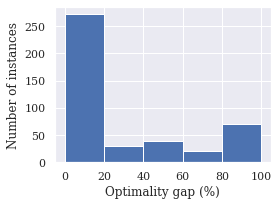

In [6]:
import matplotlib
matplotlib.rcParams.update({'font.size': 11, 'font.family': 'serif'})

_, ax = plt.subplots(figsize=(4, 3))

df = (
    pd.DataFrame
    .from_records(results)
    .assign(
        gap=lambda df: (
            df["opt_rev"]
            .subtract(df["logit_rev"])
            .divide(df["opt_rev"])
            .multiply(100)
        )
    )
)

df["gap"].hist(bins=5, ax=ax)

ax.set_xlabel("Optimality gap (%)")
ax.set_ylabel("Number of instances")
plt.tight_layout()
plt.savefig("../figs/histogram-optgap.pdf")
plt.show()